# Diffusion-based, combining item-item and user-user

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
import re
import os
from itertools import permutations

import networkx as nx
from networkx.algorithms import bipartite

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from tqdm import tqdm

In [2]:
df_movies = pd.read_csv('data/movies.dat',
                        delimiter='::', engine= 'python', encoding='ISO-8859-1', header=None,
                        names=['movie_id', 'movie_name', 'genre'])

df_users = pd.read_csv('data/users.dat',
                       delimiter='::', engine='python',  encoding='ISO-8859-1',header=None,
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

df_ratings = pd.read_csv('data/ratings.dat',
                         delimiter='::', engine='python',  encoding='ISO-8859-1',header=None,
                         names=['user_id', 'movie_id', 'rating', 'time'])

In [3]:
df_movies['year'] = df_movies.movie_name.apply(lambda x: re.findall(r'\(\d{4}\)', x)[0][1:-1])
df_ratings.drop(columns=['time'], inplace=True)

In [4]:
df_movies.head()

,movie_id,movie_name,genre,year
0,1,Toy Story (1995),Animation|Children's|Comedy,1995
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [5]:
df_users.head()

,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
df_ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


### Deal with user metadata

Add region classification

In [7]:
df_users.zip_code = df_users.zip_code.apply(lambda x: x.split('-')[0]).astype(int)

In [8]:
df_users = pd.merge(df_users, pd.read_csv('data/zip_code_database.csv'), how='left', left_on='zip_code', right_on='zip')
df_users.drop(
    columns=['decommissioned', 'primary_city', 'acceptable_cities', 'unacceptable_cities', 
             'type', 'zip', 'county', 'timezone', 'area_codes', 'world_region', 'country', 
             'latitude', 'longitude'],
    inplace=True)

In [9]:
df_users.dropna(inplace=True)

In [10]:
census_region_mapping = {
    'WEST': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'CO', 'HI', 'AK', 'NM', 'AZ'],
    'SOUTH': ['TX', 'OK', 'AR', 'LA', 'KY', 'TN', 'MS', 'AL', 'WV', 
              'VA', 'DC', 'DE', 'MD', 'NC', 'SC', 'GA', 'FL', 'PR'],
    'MIDWEST': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH'],
    'NORTHEAST': ['PA', 'NY', 'NJ', 'RI', 'CT', 'MA', 'NH', 'VT', 'ME'],
    'Other': ['GU', 'AE', 'AP']
}

def match_region(state: str) -> str:
    for k, v in census_region_mapping.items():
        if state in v:
            return k
    return state

In [11]:
df_users['region'] = df_users.state.apply(match_region)
df_users = df_users[df_users.region != 'Other']

In [12]:
df_users.isna().sum()

user_id                     0
gender                      0
age                         0
occupation                  0
zip_code                    0
state                       0
irs_estimated_population    0
region                      0
dtype: int64

Convert population to categorical

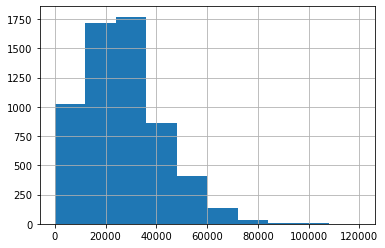

In [13]:
_ = df_users.irs_estimated_population.hist(bins=10)

In [14]:
population_bins = [0, 15000, 20000, 30000, 35000, 40000, 60000, 150000]
population_labels = [1, 2, 3, 4, 5, 6, 7]
df_users['population'] = pd.cut(df_users.irs_estimated_population, bins=population_bins, labels=population_labels)

### Divide data into subsets

In [113]:
top_5_genres = ['Drama', 'Comedy', 'Action', 'Thriller', 'Romance']

In [125]:
df_movies = df_movies[df_movies.genre.isin(top_5_genres)]

### Merge item user data and split into train and test data

In [135]:
# get rid of ratings with no zip information
df_ratings = df_ratings[df_ratings.user_id.isin(df_users.user_id)]
df_ratings = df_ratings[df_ratings.movie_id.isin(df_movies.movie_id)]
# reduce movies to those only exist in ratings
df_movies = df_movies[df_movies.movie_id.isin(df_ratings.movie_id)]

In [136]:
df_ratings_train_temp, df_ratings_test_temp = train_test_split(df_ratings, test_size=0.2, random_state=42)

In [137]:
df_ratings_train = df_ratings.copy()
df_ratings_test = df_ratings.copy()

In [138]:
df_ratings_train.loc[df_ratings_test_temp.index, 'rating'] = 0
df_ratings_test.loc[df_ratings_train_temp.index, 'rating'] = 0

In [139]:
df_ratings_train_mat = pd.pivot(df_ratings_train, index='user_id', columns='movie_id', values='rating').fillna(0).to_numpy()
df_ratings_test_mat = pd.pivot(df_ratings_test, index='user_id', columns='movie_id', values='rating').fillna(0).to_numpy()

In [140]:
df_ratings_train_mat.shape

(5906, 1455)

In [141]:
df_ratings_test_mat.shape

(5906, 1455)

In [133]:
N_users, N_movies = df_ratings_train_mat.shape

### Generate similarity matrix

In [26]:
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama',
          'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [27]:
def genre_to_arr(genres_str: str) -> np.array:
    gs = genres_str.split('|')
    genres_arr = np.zeros(len(genres))
    for i, g in enumerate(genres):
        if g in gs:
            genres_arr[i] = 1
    return genres_arr

In [28]:
def gen_sim_mat(df: pd.DataFrame, feature: str, cat: str, is_genre=False) -> np.array:
    id_col = cat + '_id'
    N = len(df)
    
    if is_genre:
        pivot_feature = np.array(df[feature].apply(genre_to_arr).tolist())
    else:
        temp = pd.concat([df, pd.DataFrame({'exist': [1] * len(df)}, index=df.index)], axis=1)
        pivot_feature = pd.pivot(temp, index=id_col, columns=feature, values='exist').fillna(0)
    
    sim = np.ones((N, N)) - pairwise_distances(pivot_feature, metric='cosine')
    return sim

Movie feature

In [29]:
movie_movie_similarity = np.ones((N_movies, N_movies)) - pairwise_distances(df_ratings_train_mat.T, metric='cosine')
movie_movie_similarity.shape

(3705, 3705)

In [30]:
year_similarity = gen_sim_mat(df_movies, 'year', 'movie')
year_similarity.shape

(3705, 3705)

In [31]:
genre_similarity = gen_sim_mat(df_movies, 'genre', 'movie', True)
genre_similarity.shape

(3705, 3705)

User feature

In [32]:
user_user_similarity = np.ones((N_users, N_users)) - pairwise_distances(df_ratings_train_mat, metric='cosine')
user_user_similarity.shape

(5964, 5964)

In [33]:
occupation_similarity = gen_sim_mat(df_users, 'occupation', 'user')
occupation_similarity.shape

(5964, 5964)

In [34]:
age_similarity = gen_sim_mat(df_users, 'age', 'user')
age_similarity.shape

(5964, 5964)

In [35]:
region_similarity = gen_sim_mat(df_users, 'region', 'user')
region_similarity.shape

(5964, 5964)

In [36]:
population_similarity = gen_sim_mat(df_users, 'population', 'user')
population_similarity.shape

(5964, 5964)

Bipartite features

In [37]:
if 'B_similarity_movies.csv' in os.listdir():
    B_similarity_movies = pd.read_csv("B_similarity_movies.csv")
    B_similarity_movies = np.array(B_similarity_movies.drop('Unnamed: 0', axis=1))
else:
    users_str = np.array([str(uid) for uid in df_users.user_id.unique()])
    df_ratings['user_id_str'] = df_ratings['user_id'].apply(str)
    
    g = nx.Graph()
    g.add_nodes_from(users_str, bipartite=0)
    g.add_nodes_from(df_movies.movie_id, bipartite=1)

    edges = df_ratings[['user_id_str', 'movie_id']].values
    g.add_edges_from(edges)

    B = bipartite.overlap_weighted_projected_graph(g, df_movies.movie_id)
    B_edges = list(B.edges(data=True))
    
    movie_id_to_index = dict(zip(df_movies.movie_id.tolist(), np.arange(N_movies)))
    
    B_similarity_movies = np.zeros((N_movies, N_movies))
    
    for i, j, weight in tqdm(B_edges):
        i = movie_id_to_index[i]
        j = movie_id_to_index[j]
        B_similarity_movies[i, j] = weight['weight']
        B_similarity_movies[j, i] = weight['weight']
        
    pd.DataFrame(B_similarity_movies).to_csv("B_similarity_movies.csv")

In [38]:
if 'B_similarity_users.csv' in os.listdir():
    B_similarity_users = pd.read_csv("B_similarity_users.csv")
    B_similarity_users = np.array(B_similarity_users.drop('Unnamed: 0', axis=1))
else:
    movies_str = np.array([str(mid) for mid in df_movies.movie_id.unique()])
    df_ratings['movie_id_str'] = df_ratings.movie_id.apply(str)
    
    g = nx.Graph()
    g.add_nodes_from(movies_str, bipartite=0)
    g.add_nodes_from(df_users.user_id, bipartite=1)

    edges = df_ratings[['movie_id_str', 'user_id']].values
    g.add_edges_from(edges)

    B = bipartite.overlap_weighted_projected_graph(g, df_users.user_id)
    B_edges = list(B.edges(data=True))
    
    user_id_to_index = dict(zip(df_users.user_id.tolist(), np.arange(N_users)))
    
    B_similarity_users = np.zeros((N_users, N_users))
    
    for i, j, weight in tqdm(B_edges):
        i = user_id_to_index[i]
        j = user_id_to_index[j]
        B_similarity_users[i, j] = weight['weight']
        B_similarity_users[j, i] = weight['weight']
        
    pd.DataFrame(B_similarity_users).to_csv("B_similarity_users.csv")

### Transition matrix

In [39]:
def feature_to_transition(feature_sim: np.array) -> np.array:
    return feature_sim / feature_sim.sum(axis=1)

Movie feature

In [40]:
movie_movie_tm = feature_to_transition(movie_movie_similarity)
year_tm = feature_to_transition(year_similarity)
genre_tm = feature_to_transition(genre_similarity)
movie_B_tm = feature_to_transition(B_similarity_movies)

User feature

In [41]:
user_user_tm = feature_to_transition(user_user_similarity)
occupation_tm = feature_to_transition(occupation_similarity)
age_tm = feature_to_transition(age_similarity)
region_tm = feature_to_transition(region_similarity)
population_tm = feature_to_transition(population_similarity)
user_B_tm = feature_to_transition(B_similarity_users)

### Prediction

In [42]:
scaler = MinMaxScaler()

In [43]:
def random_walk_predict(ratings: np.array, transition_matrix: np.array, alpha: float) -> np.array:
    x = np.eye(transition_matrix.shape[0]) - alpha * transition_matrix
    #Obtain mean of columns as you need, nanmean is convenient.
    col_mean = np.nanmean(x, axis=0)
    #Find indices that you need to replace
    inds = np.where(np.isnan(x))
    #Place column means in the indices. Align the arrays using take
    x[inds] = np.take(col_mean, inds[1])
    # GPU does not perform well on pinv function
        
    p_tilde = np.linalg.pinv(x)    
    final_rating = alpha * np.dot(ratings, np.dot(x, p_tilde))
    
    final_rating[final_rating < 0] = 0
    neglog_final_rating = 0 - np.log10(final_rating, out=np.zeros_like(final_rating), where=(final_rating != 0))
    scaled_prediction = (scaler.fit_transform(neglog_final_rating.T) * 5).T
    
    return scaled_prediction

In [44]:
def rmse(prediction: np.array, test_data_matrix: np.array, item=True) -> float:
    if item:
        mask = test_data_matrix.nonzero()
        truth = test_data_matrix[mask].flatten()
    else:
        mask = test_data_matrix.T.nonzero()
        truth = test_data_matrix.T[mask].flatten()
        
    prediction = prediction[mask].flatten()
    return sqrt(mean_squared_error(prediction, truth))

In [45]:
avg_ratings = np.nanmean(pd.pivot(df_ratings, index='user_id', columns='movie_id', values='rating').to_numpy(), axis=0)

In [61]:
def avg_nDCG_N(prediction: np.array, item=True, N=10) -> float:
    ndcgs = np.zeros(N_users)
    ranks = np.log2(np.arange(1, N + 1) + 1)
    
    for i in range(N_users):
        if item:
            top_n_idx = np.argsort(prediction[i])[::-1][:N]
        else:
            top_n_idx = np.argsort(prediction.T[i])[::-1][:N]
        
        top_n_rating = avg_ratings[top_n_idx]
        top_n_rating[np.isnan(top_n_rating)] = 0
        dcg = sum((np.power(2, top_n_rating) - 1) / ranks)
        idcg = sum((np.power(2, sorted(top_n_rating, reverse=True)) - 1) / ranks)
        ndcgs[i] = dcg / idcg
        
    return ndcgs.mean()

In [47]:
def run_grid_search(parameters: list, item=True, baseline=False) -> dict:
    results = {}
    for parameter in tqdm(parameters):
        if item: 
            alpha, beta, w1, w2, w3, w4 = parameter
            if baseline:
                transition_matrix = beta * movie_movie_tm + (1 - beta) / N_movies
                # beta * (movie_movie_tm - movie_movie_tm.mean()) / movie_movie_tm.std()
                # beta * movie_movie_tm + (1 - beta) / N_movies
            else:
                transition_matrix = beta * (w1 * movie_movie_tm + w2 * year_tm + w3 * movie_B_tm + 
                                            w4 * genre_tm) + (1 - beta) / N_movies
            try:
                prediction = random_walk_predict(df_ratings_train_mat, transition_matrix, alpha)
            except:
                print('Not convergent')
                break
        else:
            alpha, beta, w1, w2, w3, w4, w5 = parameter
            if baseline:
                transition_matrix = beta * user_user_tm + (1 - beta) / N_users
                # beta * user_user_tm + (1 - beta) / N_users
            else:
                transition_matrix = beta * (w1 * user_user_tm + w2 * population_tm + w3 * age_tm 
                                            + w4 * region_similarity 
                                            + w5 * occupation_similarity) + (1 - beta) / N_users
            try:
                prediction = random_walk_predict(df_ratings_train_mat.T, transition_matrix, alpha)
            except:
                print('Not convergent')
                break

        results[parameter] = [rmse(prediction, df_ratings_test_mat, item)]
        results[parameter].append(avg_nDCG_N(prediction, item))
    
    return results

In [64]:
def combined_grid(param_ii: tuple, param_uu: tuple, baseline=False, item=True) -> dict:
    weights = [i / 10 for i in range(11)]
    results = dict()
    
    for weight in tqdm(weights):
        # item-item
        alpha, beta, w1, w2, w3, w4 = param_ii
        transition_matrix_ii = beta * (w1 * movie_movie_tm + w2 * year_tm + w3 * movie_B_tm + 
                                            w4 * genre_tm) + (1 - beta) / N_movies
        prediction_ii = random_walk_predict(df_ratings_train_mat, transition_matrix_ii, alpha)
        
        # user-user
        alpha, beta, w1, w2, w3, w4, w5 = param_uu
        if baseline:
            transition_matrix_uu = beta * user_user_tm + (1 - beta) / N_users
        else:
            transition_matrix_uu = beta * (w1 * user_user_tm + w2 * population_tm + w3 * age_tm 
                                            + w4 * region_similarity 
                                            + w5 * occupation_similarity) + (1 - beta) / N_users
        prediction_uu = random_walk_predict(df_ratings_train_mat.T, transition_matrix_uu, alpha).T
        
        prediction_combined = weight * prediction_uu + (1 - weight) * prediction_ii
        
        result_rmse = rmse(prediction_combined, df_ratings_test_mat, item)
        result_ndcg = avg_nDCG_N(prediction_combined, item)
        results[weight] = [result_rmse, result_ndcg]
    
    return results

In [78]:
def plot_comparison(baseline_result: dict, model_result: dict) -> None:
    x = baseline_result.keys()
    # rmse
    b_rmse = [v[0] for v in baseline_result.values()]
    m_rmse = [v[0] for v in model_result.values()]
    # ndcg
    b_ndcg = [v[1] for v in baseline_result.values()]
    m_ndcg = [v[1] for v in model_result.values()]
    
    f, axs = plt.subplots(1, 2, figsize=(12, 4))
    legends = ['Baseline', 'Model']
    axs[0].plot(x, b_rmse)
    axs[0].plot(x, m_rmse)
    axs[0].set_title('RMSE')
    axs[0].set_xlabel('Factor')
    axs[0].legend(legends)
    
    axs[1].plot(x, b_ndcg)
    axs[1].plot(x, m_ndcg)
    axs[1].set_title('nDCG@10')
    axs[1].set_xlabel('Factor')
    axs[1].legend(legends)
    

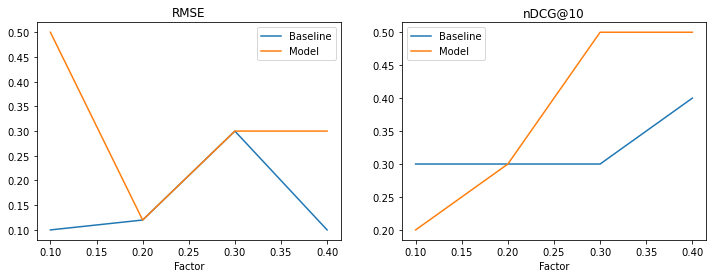

In [79]:
test1 = {0.1: [0.1, 0.3], 0.2: [0.12, 0.3], 0.3: [0.3, 0.3], 0.4: [0.1, 0.4]}
test2 = {0.1: [0.5, 0.2], 0.2: [0.12, 0.3], 0.3: [0.3, 0.5], 0.4: [0.3, 0.5]}
plot_comparison(test1, test2)

In [49]:
def generate_parameters(item=True) -> list:
    coeffs = [(0.1, 0.8)]
    ws = [0.1, 0.15, 0.2, 0.25, 0.3]
    if item:
        weights = list(permutations(ws, 4))
    else:
        weights = list(permutations(ws, 5))
    
    return [x + y for x in coeffs for y in weights]

In [50]:
def get_min(results: dict) -> None:
    print(min(results, key=results.get), results[min(results, key=results.get)])

Combined predict

In [51]:
param_ii = (0.1, 0.8, 0.4, 0.25, 0.1, 0.3)
param_uu = (0.1, 0.8, 0.2, 0.5, 0.4, 0.1, 0.3)

In [57]:
combined_grid(param_ii, param_uu)

100%|█████████████████████████████████████████████████████| 11/11 [18:29<00:00, 100.84s/it]


{(0.0, 1.0): [2.7437711883934255, 0.8591302412234643],
 (0.1, 0.9): [2.605415777576236, 0.8588286147113717],
 (0.2, 0.8): [2.4939480553096582, 0.858030133951879],
 (0.3, 0.7): [2.4130969561699747, 0.8572281236967088],
 (0.4, 0.6): [2.3660032599142995, 0.855942025160784],
 (0.5, 0.5): [2.354693275296747, 0.8523785962434202],
 (0.6, 0.4): [2.379677268934735, 0.851205088678289],
 (0.7, 0.3): [2.4398405432724424, 0.8513516875614181],
 (0.8, 0.2): [2.53267730626339, 0.851105498735297],
 (0.9, 0.1): [2.654762002041148, 0.8510276761622504],
 (1.0, 0.0): [2.8022745629320114, 0.8527056617535851]}

In [59]:
param_ii = (0.1, 0.8, 0.1, 0.4, 0.5, 0.2)
param_uu = (0.1, 0.8, 0.3, 0.2, 0.4, 0.5, 0.1)

In [62]:
combined_grid(param_ii, param_uu)

100%|█████████████████████████████████████████████████████| 11/11 [18:39<00:00, 101.73s/it]


{(0.0, 1.0): [2.733579304051077, 0.8400393436012784],
 (0.1, 0.9): [2.605471151336503, 0.8389522483715479],
 (0.2, 0.8): [2.5051812302382537, 0.8373148545216866],
 (0.3, 0.7): [2.4361475815742852, 0.8348835608909214],
 (0.4, 0.6): [2.4010676893963914, 0.8332046892362774],
 (0.5, 0.5): [2.401429996043464, 0.8329702605018791],
 (0.6, 0.4): [2.437218695503584, 0.8355029646210487],
 (0.7, 0.3): [2.5069170071041396, 0.837794044721808],
 (0.8, 0.2): [2.607807461889136, 0.8395955249503113],
 (0.9, 0.1): [2.7364421431929156, 0.8424799573302975],
 (1.0, 0.0): [2.889117584104308, 0.8472682323178251]}

Item-Item predict

In [100]:
parameters_ii = generate_parameters(True)
len(parameters_ii)

120

In [83]:
run_grid_search(parameters_ii[:1], baseline=True)

100%|████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.01s/it]


{(0.1, 0.8, 0.1, 0.15, 0.2, 0.25): [2.907849376591954, 0.8501329906148574]}

In [102]:
results_ii = run_grid_search(parameters_ii)

100%|████████████████████████████████████████████████████| 120/120 [59:30<00:00, 29.75s/it]


In [103]:
pd.DataFrame({"key": results_ii.keys(), "values": results_ii.values()}).to_pickle("results_ii.pkl")

In [106]:
df_results_ii = pd.read_pickle('results_ii.pkl')
df_results_ii['rmse'] = df_results_ii['values'].apply(lambda x: x[0])
df_results_ii['ndcg'] = df_results_ii['values'].apply(lambda x: x[1])

In [109]:
df_results_ii.sort_values('ndcg')

,key,values,rmse,ndcg
46,"(0.1, 0.8, 0.2, 0.5, 0.4, 0.1)","[2.7217906942375234, 0.8463204329553454]",2.721791,0.846320
4,"(0.1, 0.8, 0.1, 0.2, 0.5, 0.3)","[2.8013269789684796, 0.8468838818716381]",2.801327,0.846884
16,"(0.1, 0.8, 0.1, 0.4, 0.5, 0.2)","[2.889117584104308, 0.8472682323178251]",2.889118,0.847268
74,"(0.1, 0.8, 0.4, 0.1, 0.3, 0.2)","[2.7591030506631617, 0.8474396152158253]",2.759103,0.847440
47,"(0.1, 0.8, 0.2, 0.5, 0.4, 0.3)","[2.7233054659286564, 0.8474701295518238]",2.723305,0.847470
...,...,...,...,...
92,"(0.1, 0.8, 0.4, 0.5, 0.2, 0.1)","[2.790770806213055, 0.8516154083549227]",2.790771,0.851615
110,"(0.1, 0.8, 0.5, 0.3, 0.2, 0.1)","[2.7279521870985253, 0.8516366737409213]",2.727952,0.851637
91,"(0.1, 0.8, 0.4, 0.5, 0.1, 0.3)","[2.9514980859825224, 0.8520070157702323]",2.951498,0.852007
78,"(0.1, 0.8, 0.4, 0.2, 0.1, 0.3)","[2.8657746749224557, 0.8524364439944688]",2.865775,0.852436


In [122]:
parameter_ii = [(0.8, 0.8, 0.4, 0.3, 0.5, 0.2)]
run_grid_search(parameter_ii, baseline=True)

100%|████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.16s/it]


{(0.8, 0.8, 0.4, 0.3, 0.5, 0.2): [2.682395343066131, 0.8502410583201281]}

User-User predict

In [101]:
parameters_uu = generate_parameters(False)
len(parameters_uu)

120

In [77]:
run_grid_search(parameters_uu[:1], item=False, baseline=True)

100%|████████████████████████████████████████████████████████| 1/1 [01:21<00:00, 81.02s/it]


{(0.1, 0.8, 0.1, 0.15, 0.2, 0.25, 0.3): [2.7381522298048004,
  0.8574835214194814]}

In [104]:
results_uu = run_grid_search(parameters_uu, item=False)

100%|██████████████████████████████████████████████████| 120/120 [2:45:42<00:00, 82.85s/it]


In [105]:
pd.DataFrame({"key": results_uu.keys(), "values": results_uu.values()}).to_pickle("results_uu.pkl")

In [110]:
df_results_uu = pd.read_pickle('results_uu.pkl')
df_results_uu['rmse'] = df_results_uu['values'].apply(lambda x: x[0])
df_results_uu['ndcg'] = df_results_uu['values'].apply(lambda x: x[1])

In [113]:
df_results_uu.sort_values('ndcg')

,key,values,rmse,ndcg
57,"(0.1, 0.8, 0.3, 0.2, 0.4, 0.5, 0.1)","[2.733579304051077, 0.8400393436012784]",2.733579,0.840039
87,"(0.1, 0.8, 0.4, 0.3, 0.2, 0.5, 0.1)","[2.762780563921911, 0.8407327934593316]",2.762781,0.840733
61,"(0.1, 0.8, 0.3, 0.4, 0.1, 0.5, 0.2)","[2.7300988748493022, 0.8407951409845211]",2.730099,0.840795
111,"(0.1, 0.8, 0.5, 0.3, 0.2, 0.4, 0.1)","[2.764059707669867, 0.8417815640370617]",2.764060,0.841782
33,"(0.1, 0.8, 0.2, 0.3, 0.4, 0.5, 0.1)","[2.778721977572747, 0.842360785004743]",2.778722,0.842361
...,...,...,...,...
76,"(0.1, 0.8, 0.4, 0.1, 0.5, 0.2, 0.3)","[2.812924252023823, 0.8556703111655952]",2.812924,0.855670
119,"(0.1, 0.8, 0.5, 0.4, 0.3, 0.2, 0.1)","[2.783808842800227, 0.8559160801631724]",2.783809,0.855916
34,"(0.1, 0.8, 0.2, 0.3, 0.5, 0.1, 0.4)","[2.804641859746197, 0.8567054594928011]",2.804642,0.856705
118,"(0.1, 0.8, 0.5, 0.4, 0.3, 0.1, 0.2)","[2.803795023214475, 0.8573710043584952]",2.803795,0.857371


In [117]:
parameter_uu = [(0.05, 0.8, 0.2, 0.5, 0.4, 0.1, 0.3)]
run_grid_search(parameter_uu, item=False)

100%|████████████████████████████████████████████████████████| 1/1 [01:28<00:00, 88.54s/it]


{(0.05, 0.8, 0.2, 0.5, 0.4, 0.1, 0.3): [2.6932487849217086,
  0.8591992132368259]}

### Some test on code

In [53]:
# alpha, beta, w1, w2, w3 = 0.7, 0.6, 0.2, 0.4, 0.1
# transition_matrix = beta * (w1 * movie_movie_tm + w2 * year_tm + w3 * movie_B_tm + 
#                                     (1 - w1 - w2 - w3) * genre_tm) + (1 - beta) / N_movies

In [185]:
alpha, beta, w1, w2, w3, w4 = 0.7, 0.6, 0.2, 0.1, 0.2, 0.2
transition_matrix = beta * (w1 * user_user_tm + w2 * population_tm + w3 * age_tm + w4 * region_similarity + 
                                    (1 - w1 - w2 - w3 - w4) * occupation_similarity) + (1 - beta) / N_users

In [186]:
t = random_walk_predict(df_ratings_train_mat.T, transition_matrix, alpha, )
t

array([[2.77555756e-16, 1.57208261e-01, 1.57208261e-01, ...,
        1.57208261e-01, 1.57208261e-01, 1.57208261e-01],
       [3.87137585e+00, 1.54669497e-01, 1.54669497e-01, ...,
        1.54669497e-01, 1.54669497e-01, 1.54669497e-01],
       [3.84783074e+00, 1.52583660e-01, 1.52583660e-01, ...,
        1.52583660e-01, 1.52583660e-01, 1.52583660e-01],
       ...,
       [1.45743815e-01, 1.45743815e-01, 1.45743815e-01, ...,
        1.45743815e-01, 1.45743815e-01, 1.45743815e-01],
       [4.36366615e+00, 1.47689877e-01, 1.47689877e-01, ...,
        1.47689877e-01, 1.47689877e-01, 4.15418479e+00],
       [3.73569658e+00, 1.43185236e-01, 1.43185236e-01, ...,
        1.43185236e-01, 1.43185236e-01, 1.43185236e-01]])

In [189]:
np.argsort(t.T[0])[::-1][:10]

array([3064,  552, 2604, 3195, 2595, 2499, 3640,  812,  695,  975],
      dtype=int64)

In [193]:
avg_nDCG_N(t, item=False)

0.8416850539316448

In [155]:
b = avg_ratings[np.argsort(t[4])[::-1][:10]]
b

array([3.51515152, 3.1875    , 2.73809524, 3.65      , 3.42300557,
       3.56548348, 3.46938776, 3.        , 3.2519685 , 3.88461538])

In [153]:
s = np.log2(np.arange(1, len(b) + 1) + 1)
s

array([1.        , 1.5849625 , 2.        , 2.32192809, 2.5849625 ,
       2.80735492, 3.        , 3.169925  , 3.32192809, 3.45943162])

In [161]:
sum((np.power(2, b) - 1) / s) / sum((np.power(2, sorted(b, reverse=True)) - 1) / s)

0.9076973525816848

In [106]:
df_ratings_test_mat[np.all(df_ratings_test_mat == 0, axis=1)].shape

(7, 3705)

In [259]:
run_grid_search(parameters_ii[1:2], item=True, baseline=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:19<00:00, 19.25s/it]


{(0.1, 0.8, 0.1, 0.15, 0.2, 0.3): [2.99962986122377, 0.8468650425193323]}

In [261]:
run_grid_search(parameters_ii[1:5], item=True)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:17<00:00, 19.43s/it]


{(0.1, 0.8, 0.1, 0.15, 0.2, 0.3): [2.85730737383325, 0.8475588192376611],
 (0.1, 0.8, 0.1, 0.15, 0.25, 0.2): [2.7722481520651874, 0.8492745891110581],
 (0.1, 0.8, 0.1, 0.15, 0.25, 0.3): [2.7112708744303506, 0.8496553776863474],
 (0.1, 0.8, 0.1, 0.15, 0.3, 0.2): [2.932436373914119, 0.8474926122201153]}